<a href="https://colab.research.google.com/github/intandeay/Applied-Data-Science-Capstone-Project/blob/main/Segmenting_%26_Clustering_Neighborhoods_in_Toronto_(Pt_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In this assignment, several boroughs in Toronto will be selected and each neighborhoods will be clustered depending on the most occuring types of venues. The dataset is taken from the previous steps.

In [51]:
df = pd.read_csv('toronto_1.csv')

In [71]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [52]:
df.Borough.unique()

array(['North York', 'Downtown Toronto', "Queen's Park", 'Etobicoke',
       'Scarborough', 'East York', 'York', 'East Toronto', 'West Toronto',
       'East York/East Toronto', 'Central Toronto', 'Mississauga',
       'Downtown Toronto Stn A', 'Etobicoke Northwest',
       'East Toronto Business'], dtype=object)

For the purpose of this assignment, only boroughs containing the word of 'Toronto' will be clustered.

In [53]:
CLIENT_ID = '3H5SN3042TTHUSASL2EJF0BBMBDEUXNPVPFI3YX4BOUNDSXW' # your Foursquare ID
CLIENT_SECRET = 'RSBHZ1HFBVKLBCBKDH1FIDYKCBW5C0OVLL0EMWZPNP0UHBRJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Your credentails:
CLIENT_ID: 3H5SN3042TTHUSASL2EJF0BBMBDEUXNPVPFI3YX4BOUNDSXW
CLIENT_SECRET:RSBHZ1HFBVKLBCBKDH1FIDYKCBW5C0OVLL0EMWZPNP0UHBRJ


First, by using Foursquare, we will collect nearby venues for each neighborhood.

In [54]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [55]:
toronto_data = df[df['Borough'].isin(['Downtown Toronto', 'East Toronto', 'West Toronto',
       'East York/East Toronto', 'Central Toronto', 'Downtown Toronto Stn A', 
       'East Toronto Business'])].reset_index(drop=True)

toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

In [88]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


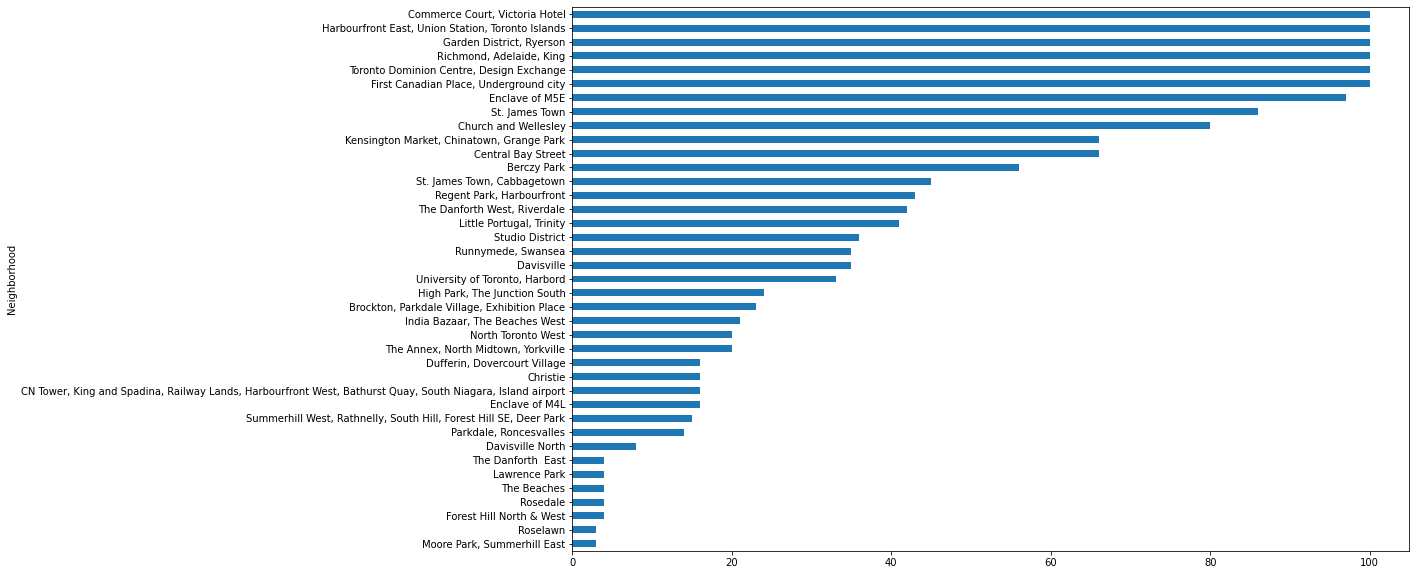

In [81]:
toronto_venues.groupby('Neighborhood').count()['Venue'].sort_values().plot.barh(figsize=(15,10))


For the boroughs with 'Toronto' word, there are 236 unique venue categories. Commerce Court, Victoria Hotel is the neighborhood with the most venues.

Next, each venues will be one-hot-encoded to categorize its type of venue and the name of neighborhood will be also included.

In [87]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + list(toronto_onehot.columns.drop('Neighborhood'))
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,...,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now, for each neighborhood, frequency of each venue type will be averaged for normalization.

In [94]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,...,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.017857,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.017857,0.053571,0.000000,0.000000,0.00,0.017857,0.017857,0.000000,0.035714,0.000000,0.000000,0.017857,0.0000,0.000000,0.0000,0.00,0.017857,0.000000,0.000000,0.00,0.000000,...,0.035714,0.000000,0.017857,0.0000,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017857,0.00,0.000000,0.000000,0.000000,0.017857,0.0000,0.000000,0.000000,0.00,0.00,0.017857,0.000000,0.00,0.000000,0.000000,0.017857,0.000000,0.0000,0.00000,0.000000,0.000000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.086957,0.000000,0.043478,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.00,0.086957,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.043478,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.0000,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.062500,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0625,0.000000,0.0625,0.00,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Central Bay Street,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.000000,0.015152,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.000000,0.000000,0.015152,0.015152,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.015152,0.0000,0.00,0.000000,0.000000,0.030303,0.00,0.030303,...,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000,0.000000,0.015152,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.015152,0.0000,0.000000,0.015152,0.00,0.00,0.000000,0.000000,0.00,0.015152,0.000000,0.015152,0.000000,0.0000,0.00000,0.000000,0.000000,0.00,0.015152,0.000000,0.000000,0.000000,0.000000,0.015152
4,Christie,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0625,0.0000,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00000

Then, for each neighborhood will be retrieved 10 most occuring type of venues.

In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [61]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Bakery,Coffee Shop,Seafood Restaurant,Cocktail Bar,Restaurant,Farmers Market,Beer Bar,Pharmacy,Cheese Shop,Bistro
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Bakery,Breakfast Spot,Burrito Place,Restaurant,Intersection,Italian Restaurant,Furniture / Home Store,Stadium
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Rental Car Location,Boutique,Harbor / Marina,Bar,Airport Gate,Airport Food Court
3,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint,Japanese Restaurant,Salad Place,Bubble Tea Shop,Restaurant,Park
4,Christie,Grocery Store,Café,Park,Candy Store,Italian Restaurant,Baby Store,Restaurant,Athletics & Sports,Nightclub,Coffee Shop


## Clustering

For clustering, k-means with 3 clusters will be applied to the toronto_grouped dataframe.

In [112]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [113]:
# add clustering labels
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis = 1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Café,Theater,Wine Shop,Event Space,Restaurant
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Coffee Shop,Clothing Store,Hotel,Bubble Tea Shop,Café,Japanese Restaurant,Cosmetics Shop,Lingerie Store,Bookstore,Pizza Place
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cosmetics Shop,Gastropub,Restaurant,Clothing Store,Cocktail Bar,Farmers Market,Bakery,Lingerie Store
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Health Food Store,Trail,Pub,Wine Shop,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Dumpling Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Bakery,Coffee Shop,Seafood Restaurant,Cocktail Bar,Restaurant,Farmers Market,Beer Bar,Pharmacy,Cheese Shop,Bistro


Now, let's see the map for the neighborhood clustering result.

In [114]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
ia=0

for idx, row in toronto_merged.iterrows():
    cluster = int(row['Cluster Labels'])
    lat = row['Latitude']
    lon = row['Longitude']
    poi = row['Neighborhood']

    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


It seems that these neighborhoods mostly come into one cluster. Let's see what might cluster these neighborhoods by inspecting the most occuring venue types for each clusters.

In [120]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,East York/East Toronto,0,Intersection,Park,Convenience Store,Wine Shop,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [121]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,1,Park,Business Service,Swim School,Bus Line,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
21,Central Toronto,1,Park,Jewelry Store,Trail,Sushi Restaurant,Wine Shop,Dessert Shop,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
29,Central Toronto,1,Gym,Trail,Park,Gourmet Shop,Event Space,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop
33,Downtown Toronto,1,Park,Playground,Trail,Department Store,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [122]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,2,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Café,Theater,Wine Shop,Event Space,Restaurant
1,Downtown Toronto,2,Coffee Shop,Clothing Store,Hotel,Bubble Tea Shop,Café,Japanese Restaurant,Cosmetics Shop,Lingerie Store,Bookstore,Pizza Place
2,Downtown Toronto,2,Coffee Shop,Café,Cosmetics Shop,Gastropub,Restaurant,Clothing Store,Cocktail Bar,Farmers Market,Bakery,Lingerie Store
3,East Toronto,2,Health Food Store,Trail,Pub,Wine Shop,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Dumpling Restaurant
4,Downtown Toronto,2,Bakery,Coffee Shop,Seafood Restaurant,Cocktail Bar,Restaurant,Farmers Market,Beer Bar,Pharmacy,Cheese Shop,Bistro
5,Downtown Toronto,2,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Burger Joint,Japanese Restaurant,Salad Place,Bubble Tea Shop,Restaurant,Park
6,Downtown Toronto,2,Grocery Store,Café,Park,Candy Store,Italian Restaurant,Baby Store,Restaurant,Athletics & Sports,Nightclub,Coffee Shop
7,Downtown Toronto,2,Coffee Shop,Café,Clothing Store,Restaurant,Thai Restaurant,Gym,Hotel,Concert Hall,Burrito Place,Bakery
8,West Toronto,2,Bakery,Pharmacy,Gym / Fitness Center,Art Gallery,Brewery,Café,Bar,Bank,Supermarket,Middle Eastern Restaurant
10,Downtown Toronto,2,Coffee Shop,Aquarium,Hotel,Café,Restaurant,Brewery,Fried Chicken Joint,Scenic Lookout,Sports Bar,Italian Restaurant


From the observations above:
1. Cluster 0 has only 1 neighborhood with the most occuring type of venues is Intersection.
2. Cluster 1 has 4 neighborhoods with Park as the most common venue type.
3. Cluster 2 with the most neighborhoods has a lot of coffee shops/cafe.